In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

In [2]:
import gym
env = gym.make('Pendulum-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
action_dim = 1
env.action_space

Box(1,)

In [4]:
obs_dim = 3
env.observation_space

Box(3,)

In [65]:
import numpy as np

def run_one_episode(env, policy, initial_state=None, max_steps=None, verbose=False, render=False):
    observation = env.reset()
    if initial_state is not None:
        env.env.state = initial_state
        observation = env.env._get_obs()
    step_idx = 0
    done = False
    total_reward = 0
    all_actions = []
    all_observations = []
    while not done:
        if render:
            env.render()
        if verbose:
            print(observation)
        action = policy(observation)
        observation, reward, done, info = env.step(action)
        all_observations.append(observation)
        all_actions.append(action)
        total_reward += reward
        step_idx += 1
        if done or (max_steps is not None and step_idx>=max_steps-1):
            print("Episode finished after {} timesteps".format(step_idx+1))
            break
    return total_reward, np.array(all_observations, dtype=np.float64,), np.array(all_actions, dtype=np.float64)
#     return total_reward, all_observations, all_actions

In [6]:
env.action_space.sample().shape

(1,)

In [7]:
def random_policy(state):
    return env.action_space.sample()

def spin_policy(state):
    return np.array(np.random.uniform(low=-2, high=0.)).reshape((1,))

In [8]:
def prepare_data(state_list, action_list, win_in):
    
    X_list = []
    Y_list = []
    
    for state_array, action_array in zip(state_list, action_list):
        # the state and action array shape should be aligned.
        assert state_array.shape[0]-1 == action_array.shape[0]
        
        for i in range(state_array.shape[0]-win_in):
            Y_list.append(state_array[i+win_in:i+win_in+1])
            X_list.append(np.hstack([state_array[i:i+win_in].flatten(), action_array[i:i+win_in].flatten()]))
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    return X, Y

In [9]:
from mxfusion import Model, Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.distributions.gp.kernels import RBF
from mxfusion.modules.gp_modules import SparseGPRegression, SparseGPRegressionSamplingPrediction
from mxfusion.modules.gp_modules import GPRegression, GPRegressionSamplingPrediction
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

    
def fit_model_synthetic(input_list, output_list, win_in, verbose=True):
#     X, Y = prepare_data(state_list, action_list, win_in)
    
#     Y_mean = Y.mean()
#     Y_std = Y.std()
#     Y = (Y-Y_mean)/(Y_std + 1e-10)
    X = input_list # [(state, action), ...]
    Y = output_list # [next state]

    m = Model()
    m.N = Variable()
    m.X = Variable(shape=(m.N, X.shape[-1]))
    m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
    m.kernel = RBF(input_dim=X.shape[-1], variance=1, lengthscale=1, ARD=True)
    m.Y = SparseGPRegression.define_variable(X=m.X, kernel=m.kernel,
                                             inducing_num = 50,
                                             noise_var=m.noise_var, shape=(m.N, Y.shape[-1]))
#     m.Y.factor.gp_log_pdf.jitter = 1e-6
    
    gp = m.Y.factor
    gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
                algorithm=SparseGPRegressionSamplingPrediction(
                    gp._module_graph,
                    gp._extra_graphs[0],
                    [gp._module_graph.X],
                    jitter = 1e-6,), 
                    alg_name='gp_predict')

    infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
    infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'),
             max_iter=1000, learning_rate=0.5, verbose=verbose)
    return m, infr #, Y_mean, Y_std
    
def fit_model(state_list, action_list, win_in, verbose=True):
    X, Y = prepare_data(state_list, action_list, win_in)
    
#     Y_mean = Y.mean()
#     Y_std = Y.std()
#     Y = (Y-Y_mean)/(Y_std + 1e-10)

    m = Model()
    m.N = Variable()
    m.X = Variable(shape=(m.N, X.shape[-1]))
    m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
    m.kernel = RBF(input_dim=X.shape[-1], variance=1, lengthscale=1, ARD=True)
    m.Y = SparseGPRegression.define_variable(X=m.X, kernel=m.kernel,
                                             inducing_num = 50,
                                             noise_var=m.noise_var, shape=(m.N, Y.shape[-1]))
#     m.Y.factor.gp_log_pdf.jitter = 1e-6
    
    gp = m.Y.factor
    gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
                algorithm=SparseGPRegressionSamplingPrediction(
                    gp._module_graph,
                    gp._extra_graphs[0],
                    [gp._module_graph.X],
                    jitter = 1e-6,), 
                    alg_name='gp_predict')

    infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
    infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'),
             max_iter=1000, learning_rate=0.5, verbose=verbose)
    return m, infr #, Y_mean, Y_std

In [10]:
all_states = []
all_actions = []

In [11]:
total_reward, states, actions = run_one_episode(env, spin_policy, max_steps=1000, render=True)
all_states.append(states)
all_actions.append(actions)

Episode finished after 201 timesteps


In [12]:
model, infr = fit_model(all_states, all_actions, win_in=1)

AssertionError: 

In [13]:
from mxfusion.inference import TransferInference, ModelBasedAlgorithm, BatchInferenceLoop
from mxnet.gluon import Block
from mxnet.gluon.parameter import ParameterDict

def run_policy(policy, cost_func, model, infr, 
                    initial_state_generator, num_grad_steps,
                    learning_rate=1e-2, num_time_steps=100, 
                    num_samples=10, verbose=True):
    
    from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
    mb_alg = ModelBasedAlgorithm(model=model, 
                                 observed=[model.X], 
                                 cost_function=cost_func, 
                                 policy=policy, 
                                 n_time_steps=num_time_steps,
                                 initial_state_generator=initial_state_generator,
                                 num_samples=num_samples)
    
    train_params = policy.collect_params() if isinstance(policy, Block) else ParameterDict()
    infr_pred = TransferInference(mb_alg, 
                                  infr_params=infr.params)
    rewards = infr_pred.run(max_iter=num_grad_steps, 
                  X=mx.nd.array(np.zeros((1,action_dim+obs_dim)), dtype='float64'),
                  verbose=verbose,
                  learning_rate=learning_rate)
    return rewards

In [14]:
from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
from mxnet.gluon import Block
from mxnet.gluon.parameter import ParameterDict

def optimize_policy(policy, cost_func, model, infr, 
                    initial_state_generator, num_grad_steps,
                    learning_rate=1e-2, num_time_steps=100, 
                    num_samples=10, verbose=True):
    
    from mxfusion.inference import GradTransferInference, ModelBasedAlgorithm, BatchInferenceLoop
    mb_alg = ModelBasedAlgorithm(model=model, 
                                 observed=[model.X], 
                                 cost_function=cost_func, 
                                 policy=policy, 
                                 n_time_steps=num_time_steps,
                                 initial_state_generator=initial_state_generator,
                                 num_samples=num_samples)
    
    train_params = policy.collect_params() if isinstance(policy, Block) else ParameterDict()
    infr_pred = GradTransferInference(mb_alg, 
                                  infr_params=infr.params, train_params=train_params)
    infr_pred.run(max_iter=num_grad_steps, 
                  X=mx.nd.array(np.zeros((1,action_dim+obs_dim)), dtype='float64'),
                  verbose=verbose,
                  learning_rate=learning_rate)
    return policy

In [15]:
class MountainCarCostFunction(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, state, action):
        return F.sum(10*(state[:,:,0:1] - 0.45)**2, axis=-1)


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

class TruePendulumCostFunction(mx.gluon.HybridBlock):
    """
    Taken from the code. True except for the action penalty
    """
    def hybrid_forward(self, F, state, action):
        cos_th, thdot = state[:,:,0], state[:,:,2]
        th = mx.nd.arccos(cos_th)
        tmp_a = mx.nd.reshape(action, shape=th.shape)
        return  - (angle_normalize(th)**2 + .1*thdot**2 + .001*(tmp_a**2))

    
class SimplePendulumCostFunction(mx.gluon.HybridBlock):
    """
    Taken from the code. True except for the action penalty
    """
    def hybrid_forward(self, F, state, action):
#         return -(F.sum((state[:,:,1:2]), axis=-1) **2)  +  + F.sum(.001*(action**2))
        a = F.sum((state[:,:,0:1]), axis=-1)
        a = -(a * F.abs(a))
#         b = F.sum(.001*(action**2))
#         c = .1*state[:,:,2:]**2
#         print("Cost breakdown: {} {} {}".format(a, b, c))
#         import pdb; pdb.set_trace()
        return a #+ b + c
    
cost = SimplePendulumCostFunction()

In [16]:
np.cos(0)

1.0

In [17]:
env.env.state = [np.pi/2, 0]
env.render()

True

In [18]:
bounds = []
for i in range(states.shape[1]):
    axis = states[:,i]
    bounds.append((np.min(axis), np.max(axis)))

In [19]:
num_samples = 20

In [20]:
class InitialStateGenerator:
    def __init__(self, bounds, dtype='float64'):
        self.bounds = bounds
        self.dtype = dtype
    def __call__(self, num_initial_states):
        states = None
        for mini, maxi in self.bounds:
            b = mx.nd.random.uniform(low=mini, high=maxi, shape=(num_initial_states, 1), dtype=self.dtype)
            if states is None:
                states = b
            else:
                states = mx.nd.concat(states, b)
        return states

In [21]:
initial_state_generator = InitialStateGenerator(bounds)

In [22]:
initial_state_generator(num_samples)


[[-0.75366498  0.14092859  0.62760722]
 [-0.64920148  0.55781604  2.16854673]
 [-0.6435176   0.20062648 -2.10916922]
 [-0.64796083  0.40238413  2.52788957]
 [-0.74090144  0.45556533  0.84108371]
 [-0.84027967  0.27901329 -1.72762067]
 [-0.87636396  0.22214669 -0.7302327 ]
 [-0.97642345  0.50394447  1.36068407]
 [-0.8867007  -0.32741369  0.59973361]
 [-0.80152116  0.14091888 -0.90657331]
 [-0.66253754 -0.22497621 -2.43332609]
 [-0.80056051  0.47630831  0.74059001]
 [-0.83678826 -0.18648735  2.47004251]
 [-0.65260311 -0.29008064  0.83922089]
 [-0.8598018  -0.04944849  0.74477054]
 [-0.73067694 -0.27166707  2.66367019]
 [-0.84698579 -0.17913675  0.46134376]
 [-0.60229682  0.02996451 -0.43078383]
 [-0.9416726   0.68733631 -0.10942886]
 [-0.63847285  0.11079518  0.68325352]]
<NDArray 20x3 @cpu(0)>

# Full PILCO

In [23]:
env.observation_space.sample()

array([0.43037874, 0.20552675, 0.71813095], dtype=float32)

In [24]:
from mxnet.gluon.nn import HybridSequential
from mxnet.gluon import HybridBlock
# Initial step

class MultiplyByTwo(HybridBlock):
    def hybrid_forward(self, F, X):
        return X * 2


class EpsilonGreed(HybridBlock):
    def __init__(self, epsilon, bounds, **kwargs):
        super(EpsilonGreed, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.bounds = bounds
    
    def hybrid_forward(self, F, X):
        p = F.random.uniform()
        if p >= self.epsilon:
            return X
        else:
            a = F.random.uniform(low=self.bounds[0],
                                 high=self.bounds[1],
                                 shape=X.shape,
                                 dtype=X.dtype)
#             print("Random action: ", a)
            return a
    
epsilon = 0.2
policy = HybridSequential()
policy.add(mx.gluon.nn.Dense(1, in_units=obs_dim, dtype='float64', activation='tanh'))
policy.add(MultiplyByTwo())
policy.add(EpsilonGreed(epsilon, (-2,2)))

# policy = mx.gluon.nn.Dense(1, in_units=2, dtype='float64')
policy.collect_params().initialize(mx.init.Xavier(magnitude=3.))

In [25]:
policy.collect_params()

hybridsequential0_ (
  Parameter dense0_weight (shape=(1, 3), dtype=float64)
  Parameter dense0_bias (shape=(1,), dtype=float64)
)

In [26]:
def sample_policy_parameters():
    weight = mx.nd.random.uniform(low=-5, high=5, shape=(1,3), dtype='float64')
    bias = mx.nd.random.uniform(low=-5, high=5, shape=(1,), dtype='float64')
    return weight, bias

In [27]:
def set_policy_parameters(policy, weight, bias):
    for n, p in policy.collect_params().items():
        if n.endswith("weight"):
            p.set_data(weight)
        else:
            p.set_data(bias)

In [61]:
INITIAL_GYM_STATE = [np.pi, 1.]
INITIAL_STATE = [np.cos(INITIAL_GYM_STATE[0]), np.sin(INITIAL_GYM_STATE[0]), INITIAL_GYM_STATE[1]]

In [62]:
def static_state_generator(num_samples):
    return mx.nd.array([INITIAL_STATE] * num_samples, dtype='float64')

In [53]:
static_state_generator(1).shape

(1, 3)

### Test Model fit on manually generated state,action pairs

In [31]:
def evaluate_pair(env, initial_state, action):
    env.env.state = initial_state
    us_initial = [np.cos(initial_state[0]), np.sin(initial_state[0]), initial_state[1]]
    observation, reward, done, info = env.step(action)
    return (us_initial, action, observation, reward)

In [32]:
def sample_state_action_pair():
    state = mx.nd.random.uniform(low=-2*np.pi, high=2*np.pi, shape=(1,2), dtype='float64')
    action = mx.nd.random.uniform(low=-2, high=2, shape=(1,), dtype='float64')
    return state.asnumpy()[0], action.asnumpy()

In [33]:
all_rewards = []
all_states = []
all_actions = []
all_obs = []
for i in range(500):
    state, action = sample_state_action_pair()
    state, action, obs, reward = evaluate_pair(env, state, action)
    all_states.append(state)
    all_actions.append(action)
    all_obs.append(obs)
    all_rewards.append(reward)

In [34]:
X = np.concatenate((np.array(all_states), np.array(all_actions)), axis=1)

In [35]:
X.shape

(500, 4)

In [36]:
Y = np.array(all_obs)

In [37]:
Y.shape

(500, 3)

In [38]:
model, infr = fit_model_synthetic(X, Y, win_in=1, verbose=True)

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 101 loss: 1076.8648133504842
Iteration 201 loss: 445.36741832639253
Iteration 301 loss: -453.62830899871194
Iteration 401 loss: -1591.7767276637605
Iteration 501 loss: -2867.6260684537774
Iteration 601 loss: -4258.6247447682545
Iteration 701 loss: -5687.3026297390465
Iteration 801 loss: -7129.4515479803085
Iteration 901 loss: -8464.1347351074225
Iteration 1000 loss: -9579.22467803955

In [39]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=model, observed=[model.X], target_variables=[model.Y], num_samples=100), 
                              infr_params=infr.params)

In [40]:
res = infr_pred.run(X=mx.nd.array(X, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [41]:
np.max(np.abs(Y - np.mean(res.asnumpy(), axis=0)))

0.0005625471202035976

### Test reward correlation from state, action pairs

In [42]:
policy_parameters = []
rewards = []
all_states = []
all_actions = []
for i in range(500):
    params = sample_policy_parameters()
    policy_parameters.append(params)
    set_policy_parameters(policy, params[0], params[1])
    policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
    true_rewards, states, actions = run_one_episode(env, random_policy, initial_state=INITIAL_GYM_STATE, max_steps=100, render=False)
    s = mx.nd.array(states)
    s = mx.nd.expand_dims(s, axis=1)
    a = mx.nd.array(actions)
    a = mx.nd.expand_dims(a, axis=1)
    
    our_rewards = -mx.nd.sum(cost(s, a))
    print(true_rewards, our_rewards)
    rewards.append(np.array([true_rewards, our_rewards.asnumpy()]))
    all_states.append(states)
    all_actions.append(actions)
rewards = np.array(rewards)

Episode finished after 2 timesteps
-9.325742777178992e-05 
[0.99999475]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0003405614622698181 
[0.9999808]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-6.232569615472472e-05 
[0.99999654]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.002455777527783326 
[0.99986184]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.003439730678557581 
[0.9998065]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.00021737408581243845 
[0.9999877]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0013616559785734807 
[0.99992335]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-1.335866233836769e-05 
[0.9999993]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-7.40809903392723e-05 
[0.9999958]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0028981197901090496 
[0.99983704]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0029441608438230704 
[0.9998344]
<NDArray 1 @cpu(

Episode finished after 2 timesteps
-0.0032797067134097235 
[0.99981546]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-4.4731608740839816e-05 
[0.9999975]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0019199834129909163 
[0.999892]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0006366717425322009 
[0.99996424]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.000656508610810306 
[0.99996305]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0015755052652204995 
[0.9999114]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.00017137697883357818 
[0.99999034]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0023238342360144913 
[0.9998692]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0001056844711545324 
[0.99999404]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0023315500959820525 
[0.99986887]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0005930945838335902 
[0.9999666]
<NDArray 1 @c

<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.002018129923337483 
[0.9998865]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-2.2824389105091797e-06 
[0.9999999]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.00033356289397170615 
[0.9999813]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.003103684876196212 
[0.9998255]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0011263597976699771 
[0.9999367]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0009893375279051817 
[0.9999443]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0026078342237464227 
[0.99985325]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.002776590050424602 
[0.99984384]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-4.358485978250415e-05 
[0.9999975]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.00011417929870080813 
[0.99999356]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0034141635723041333 
[0.99980

-0.00016313417276455765 
[0.9999908]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0026120299018884906 
[0.99985313]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0005777521113393256 
[0.99996746]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0006375834050774678 
[0.9999641]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.00047488414897907204 
[0.9999733]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0010549644626372014 
[0.99994063]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0002962017816635729 
[0.9999833]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0010814313176124414 
[0.9999392]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.001843742257425575 
[0.9998963]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0014055666182102868 
[0.99992096]
<NDArray 1 @cpu(0)>
Episode finished after 2 timesteps
-0.0033733437029415114 
[0.9998102]
<NDArray 1 @cpu(0)>
Episode finished after 2 time

Episode finished after 2 timesteps
-0.0010047659303818932 
[0.9999435]
<NDArray 1 @cpu(0)>


### Test  reward correlations from full runs

In [68]:
policy_parameters = []
rewards = []
timesteps = 5
for i in range(100):
    params = sample_policy_parameters()
    policy_parameters.append(params)
    set_policy_parameters(policy, params[0], params[1])
    policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
    true_rewards, states, actions = run_one_episode(env, policy_func,
                                                    initial_state=INITIAL_GYM_STATE,
                                                    max_steps=timesteps, render=False)
    print("True states:", states)
    our_costs, _ = run_policy(policy, cost, model, infr, 
                    static_state_generator, 100,
                    learning_rate=1e-2, num_time_steps=timesteps, 
                    num_samples=10, verbose=True)
    our_costs = -our_costs
    print("Rewards: ", true_rewards, our_costs.asnumpy())
    rewards.append(np.array([true_rewards, our_costs.asnumpy()]))
rewards = np.array(rewards)

Episode finished after 5 timesteps
True states: [[-0.99938756 -0.03499305  0.700004  ]
 [-0.998559   -0.0536649   0.37380975]
 [-0.99692787 -0.0783251   0.49429435]
 [-0.99637302 -0.08509292  0.13581079]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99973427 -0.0352901   0.69961983]]

 [[-0.99917137 -0.03467066  0.70003072]]

 [[-0.99936823 -0.03514383  0.69953939]]

 [[-0.99883251 -0.03502745  0.70031589]]

 [[-0.99934995 -0.0347718   0.70049462]]

 [[-0.99897308 -0.03492532  0.6997888 ]]

 [[-0.9990937  -0.034767

/Users/erimeiss/workspace/pilco/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


[[-0.99788824 -0.06495424  1.3       ]
 [-0.98985492 -0.14208178  1.55128432]
 [-0.97371189 -0.22778314  1.74472299]
 [-0.94813033 -0.31788188  1.87388563]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99801099 -0.06481077  1.30013839]]

 [[-0.99792503 -0.06510257  1.29998334]]

 [[-0.99819801 -0.06484264  1.30007424]]

 [[-0.997926   -0.06505419  1.29976088]]

 [[-0.99819307 -0.0650003   1.30011513]]

 [[-0.99806485 -0.06477538  1.30011259]]

 [[-0.99829428 -0.06499628  1.30006771]]

 [[-0.99824389 -0.06484535  1.

<NDArray 10x3 @cpu(0)>
state:  
[[[-0.9994223  -0.03514277  0.69998458]]

 [[-0.99966372 -0.03459448  0.70001758]]

 [[-0.99962084 -0.03470465  0.70002911]]

 [[-0.99974356 -0.03509531  0.70043465]]

 [[-0.99958923 -0.03521575  0.69994216]]

 [[-0.99918565 -0.03485605  0.70022125]]

 [[-0.99938128 -0.03455966  0.7003844 ]]

 [[-0.99963084 -0.03471418  0.70033193]]

 [[-0.99945997 -0.03484601  0.69974189]]

 [[-0.99971795 -0.03485405  0.70048374]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99838703 -0.05348224  0.37411946]]

 [[-0.99899486 -0.05344404  0.37432983]]

 [[-0.99925785 -0.05354361  0.374119  ]]

 [[-0.99884991 -0.05404251  0.37413537]]

 [[-0.99872097 -0.0536866   0.37321416]]

 [[-0.99837848 -0.05349002  0.37418669]]

 [[-0.99887101 -0.05347115  0.37447113]]

 [[-0.99888014 -0.05287098  0.37418191]]

 [[-0.99923429 -0.05340907  0.3739871 ]]

 [[-0.99913542 -0.053942    0.37493267]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99858323 -0.05501641  0.03418544]]

 [[-0.99843664 -0.

state:  
[[[-0.99781115 -0.07194859  0.74394086]]

 [[-0.99873322 -0.06197847  0.54513563]]

 [[-0.99741029 -0.06589461  0.6285036 ]]

 [[-0.99823004 -0.06493549  0.60407387]]

 [[-0.99714417 -0.0816635   0.94467991]]

 [[-0.99847    -0.05445676  0.39098093]]

 [[-0.99792211 -0.06284505  0.55612078]]

 [[-0.99774193 -0.06978897  0.70587058]]

 [[-0.9982302  -0.05682632  0.44303102]]

 [[-0.99856484 -0.0564629   0.43414433]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99634101 -0.09118876  0.3902945 ]]

 [[-0.99798612 -0.07206723  0.19896843]]

 [[-0.99699101 -0.07980828  0.2792384 ]]

 [[-0.99713337 -0.07811952  0.25578477]]

 [[-0.99450939 -0.11026021  0.58321631]]

 [[-0.99845087 -0.05700027  0.05074103]]

 [[-0.99748393 -0.07332005  0.20904407]]

 [[-0.99664531 -0.08735459  0.35354078]]

 [[-0.99808514 -0.06186664  0.10039245]]

 [[-0.99855714 -0.06143175  0.09220294]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99614588 -0.09211     0.0216687 ]]

 [[-0.99921778 -0.06437347 -0.15499354]]


state:  
[[[-0.98673951 -0.16320638  0.8479042 ]]

 [[-0.97978482 -0.19883666  1.35861796]]

 [[-0.97501094 -0.22382498  1.68209669]]

 [[-0.98241558 -0.18534288  1.29080801]]

 [[-0.98224703 -0.18933828  1.08381419]]

 [[-0.98118305 -0.19281497  1.33549954]]

 [[-0.98535604 -0.17004797  1.0726945 ]]

 [[-0.98828896 -0.15484971  0.76450089]]

 [[-0.98152903 -0.19081973  1.27214818]]

 [[-0.97943239 -0.20145176  1.39460494]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.97694156 -0.21380121  1.02534783]]

 [[-0.96222379 -0.27211222  1.50961011]]

 [[-0.95068025 -0.31105079  1.81445092]]

 [[-0.96686732 -0.25596494  1.45160649]]

 [[-0.96829664 -0.24987065  1.24170139]]

 [[-0.96411091 -0.26517312  1.49072909]]

 [[-0.97281182 -0.23086843  1.24494003]]

 [[-0.97987501 -0.2014926   0.94794306]]

 [[-0.96569201 -0.26026971  1.42921218]]

 [[-0.96158871 -0.27629511  1.5434212 ]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.96322617 -0.27026072  1.16486017]]

 [[-0.93732436 -0.34851688  1.60547723]]


state:  
[[[-0.99941704 -0.03892015 -0.30743953]]

 [[-1.00073385 -0.04038433 -0.30783236]]

 [[-0.99891183 -0.03934586 -0.30629163]]

 [[-0.99936064 -0.04014883 -0.30827878]]

 [[-0.99939095 -0.04048763 -0.30841602]]

 [[-0.99922871 -0.04027647 -0.30793794]]

 [[-0.99994347 -0.03919572 -0.30774588]]

 [[-1.00019576 -0.04014921 -0.30775111]]

 [[-0.99935456 -0.04006529 -0.30712455]]

 [[-0.99947635 -0.03983309 -0.30663334]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-1.00005862 -0.02156411 -0.3460157 ]]

 [[-1.00131962 -0.01146297 -0.5812355 ]]

 [[-0.99951623 -0.01002567 -0.58985542]]

 [[-1.00054366 -0.00938338 -0.61617041]]

 [[-0.99996551 -0.02273486 -0.35409061]]

 [[-0.99958561 -0.03178053 -0.17079575]]

 [[-1.00073907 -0.0086034  -0.60944494]]

 [[-1.00059699 -0.03126224 -0.17927706]]

 [[-1.00007897 -0.01266032 -0.55194703]]

 [[-1.00022995 -0.01427923 -0.51241941]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.26016237172572 [-49.93480056]
Episode finished after 5 timesteps
True states: 

state:  
[[[-0.97656103 -0.21301317  0.78731911]]

 [[-0.9728877  -0.22884082  0.80953316]]

 [[-0.97203567 -0.2317433   0.81662561]]

 [[-0.97889566 -0.20364211  0.77845395]]

 [[-0.97352958 -0.22570802  0.79711509]]

 [[-0.97653823 -0.21406491  0.78419364]]

 [[-0.97740417 -0.2101875   0.79889467]]

 [[-0.98114861 -0.19077944  0.77136819]]

 [[-0.97193534 -0.23215798  0.81606843]]

 [[-0.97975525 -0.19810252  0.77377011]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.08618246255344 [-48.88844472]
Episode finished after 5 timesteps
True states: [[-0.99788824 -0.06495424  1.3       ]
 [-0.99288719 -0.11905895  1.08684069]
 [-0.98698315 -0.1608237   0.84366254]
 [-0.97746928 -0.21107773  1.02304476]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-

Episode finished after 5 timesteps
True states: [[-0.9979365  -0.06420857  1.2850555 ]
 [-0.99007878 -0.14051341  1.5345435 ]
 [-0.97425346 -0.22545552  1.72861247]
 [-0.94911712 -0.31492331  1.85930561]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99786605 -0.06410444  1.28517062]]

 [[-0.99803844 -0.06376565  1.28520132]]

 [[-0.998168   -0.064156    1.2850508 ]]

 [[-0.99811714 -0.06424323  1.28488995]]

 [[-0.9981888  -0.06445246  1.28497921]]

 [[-0.99802707 -0.06418248  1.2847644 ]]

 [[-0.99795101 -0.064032

s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99807349 -0.06368006  1.27885683]]

 [[-0.99793126 -0.06387634  1.27866583]]

 [[-0.99791267 -0.06395458  1.27858276]]

 [[-0.9980134  -0.06400516  1.27855016]]

 [[-0.99834695 -0.06402128  1.27852713]]

 [[-0.99806187 -0.06372323  1.27866617]]

 [[-0.99795278 -0.06378201  1.27822449]]

 [[-0.99794732 -0.06368765  1.2790117 ]]

 [[-0.99823839 -0.06377271  1.2785009 ]]

 [[-0.99800273 -0.06380386  1.27846072]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.9911573  -0.13516223 

state:  
[[[-0.99883336 -0.04058303  0.81197649]]

 [[-0.99908576 -0.04106177  0.82643372]]

 [[-0.99973649 -0.03532476  0.7091928 ]]

 [[-0.99819033 -0.06470201  1.29609358]]

 [[-0.9997083  -0.03584752  0.71288039]]

 [[-0.99980842 -0.03589938  0.72805156]]

 [[-0.99864894 -0.05167275  1.0330475 ]]

 [[-0.99840455 -0.0540388   1.08369898]]

 [[-0.99833448 -0.05588952  1.11881941]]

 [[-0.99817449 -0.06255494  1.25749858]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99551479 -0.09454822  1.08178002]]

 [[-0.9953431  -0.09581338  1.0954736 ]]

 [[-0.99667272 -0.08440079  0.98298541]]

 [[-0.99017528 -0.1416091   1.54751289]]

 [[-0.99668636 -0.08512863  0.98598122]]

 [[-0.99705845 -0.08576351  1.00108956]]

 [[-0.9932499  -0.11604768  1.29423727]]

 [[-0.9927345  -0.12058303  1.34292681]]

 [[-0.9921816  -0.12448925  1.37662848]]

 [[-0.99093036 -0.1372995   1.51067544]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.98723124 -0.15922561  1.31100016]]

 [[-0.98681109 -0.16130966  1.3237649 ]]


state:  
[[[-0.99262155 -0.12202368  1.18968612]]

 [[-0.99154826 -0.13205246  1.38474415]]

 [[-0.99138187 -0.12808731  1.30828837]]

 [[-0.99164508 -0.12776631  1.2960074 ]]

 [[-0.99414328 -0.11050713  0.9583584 ]]

 [[-0.99398074 -0.1110011   0.96703763]]

 [[-0.99229263 -0.12233096  1.19048456]]

 [[-0.99356292 -0.1127861   0.99332095]]

 [[-0.99148391 -0.13106977  1.36489015]]

 [[-0.99357525 -0.11565733  1.05792416]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.98391171 -0.17798445  1.13766888]]

 [[-0.98292726 -0.18435265  1.06062898]]

 [[-0.98275502 -0.18158587  1.08749084]]

 [[-0.98160336 -0.19010445  1.26749022]]

 [[-0.98881405 -0.15114847  0.82626502]]

 [[-0.98722478 -0.16115098  1.01463309]]

 [[-0.98240148 -0.18667625  1.30669085]]

 [[-0.9893707  -0.14526044  0.65733847]]

 [[-0.98181217 -0.19063959  1.20777773]]

 [[-0.98703538 -0.16130213  0.92407844]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.97079004 -0.23990267  1.2628186 ]]

 [[-0.9704722  -0.24207355  1.18040917]]


state:  
[[[-0.97435494 -0.22740904  1.74504973]]

 [[-0.97392529 -0.22763994  1.74483882]]

 [[-0.9740658  -0.22742566  1.74486616]]

 [[-0.97389901 -0.22773825  1.745538  ]]

 [[-0.97467309 -0.22727283  1.74465008]]

 [[-0.97373009 -0.22736071  1.74483285]]

 [[-0.97428793 -0.2277428   1.74456201]]

 [[-0.97393545 -0.22741037  1.74407932]]

 [[-0.97454076 -0.22793699  1.74504408]]

 [[-0.97405763 -0.22711192  1.74488039]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.94869789 -0.31750624  1.8741626 ]]

 [[-0.94820443 -0.31750533  1.87446244]]

 [[-0.94830596 -0.31750956  1.87421602]]

 [[-0.94836951 -0.31793762  1.87475849]]

 [[-0.94944783 -0.31737815  1.87419087]]

 [[-0.94851153 -0.31731783  1.87434854]]

 [[-0.94861607 -0.31792326  1.873743  ]]

 [[-0.94843756 -0.31748985  1.87366429]]

 [[-0.94938628 -0.31810548  1.87439441]]

 [[-0.94876815 -0.31722763  1.87471103]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.9136333  -0.40753124  1.93601509]]

 [[-0.91341561 -0.40741008  1.93658526]]


state:  
[[[-0.99443275 -0.10599505  0.22832402]]

 [[-0.9941595  -0.10633641  0.22658966]]

 [[-0.99376058 -0.10618605  0.22836211]]

 [[-0.99475985 -0.10624696  0.22829594]]

 [[-0.99399881 -0.10612382  0.2276337 ]]

 [[-0.99416928 -0.10583119  0.2287499 ]]

 [[-0.99391545 -0.10613308  0.22856471]]

 [[-0.99466994 -0.10641154  0.22748827]]

 [[-0.99419443 -0.10666581  0.22582723]]

 [[-0.99445698 -0.10617721  0.22786788]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99403103 -0.10897713  0.06022601]]

 [[-0.99361711 -0.10899669  0.05802141]]

 [[-0.99330726 -0.10895554  0.05926354]]

 [[-0.99432887 -0.10912679  0.05962966]]

 [[-0.99360056 -0.10896078  0.05902883]]

 [[-0.99395412 -0.10865946  0.0605204 ]]

 [[-0.9935405  -0.10893666  0.05938753]]

 [[-0.99437856 -0.10941762  0.05862747]]

 [[-0.99379127 -0.10917472  0.05685788]]

 [[-0.99406926 -0.1089207   0.05947801]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.40476858896275 [-49.59998881]
Episode finished after 5 timesteps
True states: 

state:  
[[[-0.99024606 -0.13999039  0.06169882]]

 [[-0.99490527 -0.11324433 -0.11969654]]

 [[-0.99842519 -0.05882982 -0.34126368]]

 [[-0.99477849 -0.1072463  -0.11443046]]

 [[-0.99007385 -0.1447817   0.0812093 ]]

 [[-0.99394019 -0.11106088 -0.08659408]]

 [[-0.99898194 -0.04365232 -0.45219225]]

 [[-1.0009145  -0.01219944 -0.61705828]]

 [[-1.00001616 -0.03959158 -0.49149255]]

 [[-0.99638365 -0.08822307 -0.26683995]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.75957253925509 [-49.68431749]
Episode finished after 5 timesteps
True states: [[-0.99789126 -0.0649079   1.29907133]
 [-0.99282803 -0.11955125  1.09768615]
 [-0.98290119 -0.18413379  1.30705279]
 [-0.96674288 -0.25575027  1.46866387]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-

state:  
[[[-0.98162224 -0.18931569  0.31728327]]

 [[-0.96167371 -0.27635358  0.79126941]]

 [[-0.99386815 -0.11289826  0.423874  ]]

 [[-0.95143685 -0.3071314   1.13694487]]

 [[-0.93162671 -0.36443632  1.52406578]]

 [[-0.96914187 -0.24701523  1.18773645]]

 [[-0.99433667 -0.11040748  0.30278253]]

 [[-0.9663318  -0.25592757  0.68939243]]

 [[-0.93597484 -0.3533398   1.28536065]]

 [[-0.96125906 -0.27412137  0.80494284]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -37.84410489034084 [-48.42091449]
Episode finished after 5 timesteps
True states: [[-0.99938304 -0.03512179  0.70258028]
 [-0.99847873 -0.05513821  0.40074356]
 [-0.99771072 -0.06762629  0.25023495]
 [-0.9969252  -0.07835908  0.21523102]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-

Episode finished after 5 timesteps
True states: [[-0.99788826 -0.06495405  1.29999631]
 [-0.99291221 -0.11885005  1.08263664]
 [-0.98315509 -0.18277328  1.29349733]
 [-0.96725152 -0.2538198   1.45641674]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99866751 -0.05139911  1.03279743]]

 [[-0.99850411 -0.04968111  0.99611308]]

 [[-0.99808877 -0.06349858  1.27150357]]

 [[-0.99865022 -0.0478867   0.95968132]]

 [[-0.99952359 -0.03789027  0.76051181]]

 [[-0.99903118 -0.04288226  0.86003618]]

 [[-0.9993604  -0.037755

True states: [[-0.99898002 -0.04515446  0.90339629]
 [-0.99586284 -0.0908692   0.91649812]
 [-0.98903668 -0.14767004  1.14434705]
 [-0.977012   -0.21318429  1.33241903]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99796226 -0.06454746  1.29408534]]

 [[-0.99802934 -0.06429879  1.29430168]]

 [[-0.99785983 -0.06458339  1.29438155]]

 [[-0.99785652 -0.06437205  1.29404259]]

 [[-0.99775076 -0.0646732   1.2941405 ]]

 [[-0.99825262 -0.06444554  1.29427384]]

 [[-0.9978631  -0.06453032  1.29432064]]

 [[-0.99784669 -0

state:  
[[[-0.99888846 -0.04348029  0.87131754]]

 [[-0.99890248 -0.04341789  0.87128891]]

 [[-0.99896356 -0.04340061  0.87135595]]

 [[-0.99904964 -0.04354923  0.87147197]]

 [[-0.99886893 -0.04353612  0.87118723]]

 [[-0.99861475 -0.04322432  0.87130139]]

 [[-0.99898636 -0.04359077  0.87123648]]

 [[-0.99886755 -0.04334162  0.87138389]]

 [[-0.99890724 -0.04348148  0.87106278]]

 [[-0.9992593  -0.04350939  0.8711681 ]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99650678 -0.08265572  0.78525819]]

 [[-0.99636729 -0.08256526  0.78553186]]

 [[-0.99631226 -0.08248426  0.78564337]]

 [[-0.99672839 -0.08252607  0.78546709]]

 [[-0.99615264 -0.0827223   0.78507866]]

 [[-0.99628513 -0.08227751  0.78530347]]

 [[-0.99652325 -0.0824879   0.78524155]]

 [[-0.9965354  -0.08251037  0.78557127]]

 [[-0.9962813  -0.08263703  0.78538413]]

 [[-0.99667165 -0.08267559  0.78589347]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99305092 -0.11801293  0.71237153]]

 [[-0.99273105 -0.11780464  0.712169  ]]


state:  
[[[-0.99684666 -0.08284929  0.46560162]]

 [[-0.99676194 -0.07744987  0.34671872]]

 [[-0.99661957 -0.08570508  0.49566884]]

 [[-0.99772595 -0.06936302  0.17304979]]

 [[-0.9978227  -0.07467649  0.28872962]]

 [[-0.99602206 -0.08887985  0.5767337 ]]

 [[-0.99796958 -0.07282111  0.24086816]]

 [[-0.99597808 -0.08809418  0.55347072]]

 [[-0.99719438 -0.07175144  0.22185138]]

 [[-0.99624845 -0.0863364   0.51238092]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99407923 -0.11022778  0.55360601]]

 [[-0.99427548 -0.10407779  0.53312202]]

 [[-0.9938696  -0.11283458  0.54511691]]

 [[-0.99636276 -0.09017705  0.41048992]]

 [[-0.99564179 -0.09953299  0.50040237]]

 [[-0.99346125 -0.11407823  0.50749449]]

 [[-0.99606148 -0.09617212  0.46594486]]

 [[-0.99336227 -0.11383878  0.51963962]]

 [[-0.99556979 -0.09432259  0.45110827]]

 [[-0.99350166 -0.11299197  0.53886887]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.9909471  -0.13512239  0.50096235]]

 [[-0.99120634 -0.12955165  0.51540927]]


state:  
[[[-0.99862144 -0.05571356  0.04075472]]

 [[-0.99885215 -0.05546645  0.04183146]]

 [[-0.99802458 -0.05619433  0.04094591]]

 [[-0.99951812 -0.05609767  0.03945976]]

 [[-0.99913543 -0.05518798  0.04234325]]

 [[-0.99761858 -0.05596353  0.04057371]]

 [[-0.99890102 -0.05489165  0.0408074 ]]

 [[-0.9996492  -0.0554288   0.04238616]]

 [[-0.99858666 -0.05668761  0.04009549]]

 [[-0.99866927 -0.05529127  0.04085836]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99911399 -0.0423895  -0.26982147]]

 [[-0.99926048 -0.04205083 -0.26834501]]

 [[-0.99885009 -0.04263658 -0.26993977]]

 [[-1.00057937 -0.04246035 -0.27103096]]

 [[-1.00001975 -0.0417523  -0.26816179]]

 [[-0.99831603 -0.04234888 -0.26993105]]

 [[-0.9994463  -0.04160002 -0.26948745]]

 [[-1.00038028 -0.04195406 -0.26825527]]

 [[-0.9990865  -0.04304837 -0.27079513]]

 [[-0.99973537 -0.04161018 -0.26941577]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99997903 -0.0179319  -0.48621054]]

 [[-1.00018852 -0.01779013 -0.4850186 ]]


state:  
[[[-0.99953384 -0.0392855  -0.3056657 ]]

 [[-0.9996255  -0.03966795 -0.30691494]]

 [[-0.99955196 -0.03929708 -0.30598668]]

 [[-0.99996508 -0.04010428 -0.30709244]]

 [[-0.99968093 -0.03916341 -0.30636489]]

 [[-0.99971812 -0.03992389 -0.30722353]]

 [[-1.0003138  -0.03987163 -0.30729929]]

 [[-0.99952659 -0.03962357 -0.30745164]]

 [[-0.99935197 -0.03863055 -0.30639723]]

 [[-1.00041061 -0.04057189 -0.30882683]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-1.00049127 -0.00729142 -0.6348704 ]]

 [[-1.00049862 -0.00792401 -0.63621416]]

 [[-1.00036004 -0.00747519 -0.63498469]]

 [[-1.00102817 -0.00840512 -0.63711496]]

 [[-1.00043899 -0.00757073 -0.63536392]]

 [[-1.00056248 -0.00806272 -0.63694671]]

 [[-1.00147376 -0.00791456 -0.63714009]]

 [[-1.00049706 -0.00818871 -0.63700605]]

 [[-1.00025399 -0.00630444 -0.63496954]]

 [[-1.00132482 -0.00833394 -0.63916565]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.75957073826454 [-49.9504279]
Episode finished after 5 timesteps
True states: [

state:  
[[[-0.92269358 -0.38546288  1.46528169]]

 [[-0.92464324 -0.38163453  1.38688638]]

 [[-0.92311261 -0.38603982  1.44839803]]

 [[-0.91946985 -0.39398213  1.63207338]]

 [[-0.92208601 -0.38894777  1.51999362]]

 [[-0.91740305 -0.39854434  1.74190414]]

 [[-0.92271228 -0.38604782  1.46715034]]

 [[-0.91566253 -0.40285955  1.82004537]]

 [[-0.92087843 -0.39086215  1.56104293]]

 [[-0.9262875  -0.38018565  1.3404203 ]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -37.836730474070336 [-46.74131649]
Episode finished after 5 timesteps
True states: [[-0.9993869  -0.0350118   0.70037924]
 [-0.99855548 -0.05373034  0.37474532]
 [-0.99845884 -0.05549719  0.03538987]
 [-0.99835472 -0.05733986  0.03691206]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [

Episode finished after 5 timesteps
True states: [[-0.99879683 -0.0490398   0.98118952]
 [-0.99669719 -0.08120787  0.64475832]
 [-0.99543061 -0.09548769  0.28672008]
 [-0.99421991 -0.10736281  0.23873498]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99929658 -0.03483608  0.70045031]]

 [[-0.99923427 -0.03475964  0.70038601]]

 [[-0.99934745 -0.03431377  0.7000649 ]]

 [[-0.99966243 -0.03476244  0.70040585]]

 [[-0.99964609 -0.03474318  0.70094557]]

 [[-0.99964615 -0.03467835  0.70051007]]

 [[-0.99935579 -0.034748

s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99818714 -0.05933663  1.18860523]]

 [[-0.99802142 -0.06325892  1.2635323 ]]

 [[-0.99806977 -0.06317154  1.26681159]]

 [[-0.9986395  -0.05024317  1.00447413]]

 [[-0.99943486 -0.03766154  0.75084021]]

 [[-0.99788629 -0.06305899  1.26121758]]

 [[-0.99898311 -0.04719508  0.94319284]]

 [[-0.99819654 -0.05725589  1.14686101]]

 [[-0.99877808 -0.04427121  0.88708003]]

 [[-0.99880793 -0.0492596   0.98787847]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99135061 -0.13048405 

state:  
[[[-0.99813908 -0.06490713  1.29987556]]

 [[-0.99808618 -0.06483002  1.29978267]]

 [[-0.99800588 -0.0648908   1.30008485]]

 [[-0.99796397 -0.06478658  1.29980807]]

 [[-0.99806089 -0.06493061  1.29987277]]

 [[-0.99799377 -0.06510559  1.29972722]]

 [[-0.99825491 -0.06481921  1.29996093]]

 [[-0.99781027 -0.06483551  1.30009876]]

 [[-0.99801246 -0.06488242  1.29970606]]

 [[-0.99815266 -0.06487124  1.30005005]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99026738 -0.1419691   1.55111979]]

 [[-0.99000337 -0.14201171  1.55094383]]

 [[-0.99003309 -0.14185952  1.55150844]]

 [[-0.99022215 -0.14196325  1.55114149]]

 [[-0.99015028 -0.14193963  1.55133824]]

 [[-0.98993349 -0.14199959  1.55085092]]

 [[-0.99041661 -0.14176819  1.55128551]]

 [[-0.99018554 -0.14181704  1.55140616]]

 [[-0.98997627 -0.141872    1.55089168]]

 [[-0.99022232 -0.14184243  1.55114465]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.97425076 -0.22764181  1.74444463]]

 [[-0.97419978 -0.22737911  1.74448342]]


state:  
[[[-0.99048727 -0.14041938  1.53606979]]

 [[-0.99042707 -0.1402703   1.53658497]]

 [[-0.98995298 -0.14029488  1.53621259]]

 [[-0.9905091  -0.14026138  1.5362058 ]]

 [[-0.98997985 -0.14027451  1.53581098]]

 [[-0.99076339 -0.14058401  1.53620016]]

 [[-0.99019714 -0.14057958  1.53639069]]

 [[-0.99026176 -0.14046316  1.53599878]]

 [[-0.99056618 -0.14071851  1.53615115]]

 [[-0.99041859 -0.1404102   1.53590209]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.97484123 -0.22525922  1.73035383]]

 [[-0.9747872  -0.2253461   1.73106284]]

 [[-0.9745114  -0.22496871  1.7304818 ]]

 [[-0.97490783 -0.22499234  1.73079878]]

 [[-0.97444646 -0.22529282  1.73022446]]

 [[-0.97504107 -0.22545298  1.73066625]]

 [[-0.97428155 -0.2254291   1.73054688]]

 [[-0.97466307 -0.22531991  1.73022628]]

 [[-0.97518837 -0.22572954  1.73049165]]

 [[-0.97476935 -0.22551132  1.73021441]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.94966653 -0.31493985  1.86146747]]

 [[-0.94984918 -0.31515834  1.86175308]]


state:  
[[[-0.9967903  -0.08448125  0.97684449]]

 [[-0.9988258  -0.05787047  0.44818297]]

 [[-0.99833476 -0.06356254  0.56429079]]

 [[-0.99705533 -0.07214153  0.74040992]]

 [[-0.99644729 -0.08397713  0.97196254]]

 [[-0.997436   -0.06514483  0.57999679]]

 [[-0.99783939 -0.07168595  0.71884718]]

 [[-0.99826928 -0.06905399  0.67002079]]

 [[-0.99773311 -0.06967974  0.6740851 ]]

 [[-0.99805807 -0.06132472  0.50941733]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99359124 -0.11613368  0.64081699]]

 [[-0.99887374 -0.06287371  0.10540951]]

 [[-0.99797778 -0.07417492  0.21770771]]

 [[-0.99586573 -0.09189551  0.39033238]]

 [[-0.99347659 -0.1154481   0.63527525]]

 [[-0.9964796  -0.07708742  0.23255159]]

 [[-0.99564336 -0.09017364  0.36884622]]

 [[-0.99672617 -0.08479866  0.32085452]]

 [[-0.99648749 -0.08587315  0.32450402]]

 [[-0.99761027 -0.06942639  0.16351332]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99191181 -0.12911115  0.25663725]]

 [[-0.99933507 -0.05057526 -0.24159177]]


state:  
[[[-0.99904732 -0.03945276 -0.30793133]]

 [[-1.00005653 -0.03897873 -0.30710898]]

 [[-0.99984685 -0.03890351 -0.30698388]]

 [[-0.99946488 -0.0396476  -0.30757244]]

 [[-1.00003748 -0.03915018 -0.3058589 ]]

 [[-0.99954392 -0.0393464  -0.30728397]]

 [[-0.99939979 -0.03980237 -0.30616447]]

 [[-0.99957869 -0.04039114 -0.30663759]]

 [[-1.00009529 -0.03992513 -0.30751334]]

 [[-0.99976226 -0.0388538  -0.30619039]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-1.00026769 -0.00783684 -0.63660986]]

 [[-1.00083488 -0.00700348 -0.63572603]]

 [[-1.00078779 -0.00715106 -0.63495193]]

 [[-0.99993295 -0.00773378 -0.63645678]]

 [[-1.00089309 -0.00762968 -0.63454206]]

 [[-1.00062001 -0.00762593 -0.63584467]]

 [[-1.00042528 -0.00825443 -0.63531123]]

 [[-1.00051616 -0.00869773 -0.63600019]]

 [[-1.00078506 -0.00809824 -0.63640393]]

 [[-1.00058886 -0.00751736 -0.63432361]]]
<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.23409115588687 [-49.94456662]
Episode finished after 5 timesteps
True states: 

state:  
[[[-0.99895503 -0.05787414  0.08821223]]

 [[-0.99797952 -0.07054447  0.34945555]]

 [[-0.9972067  -0.07897863  0.50336616]]

 [[-0.99691304 -0.07787757  0.49959843]]

 [[-0.99806397 -0.07084287  0.35212543]]

 [[-0.99625515 -0.08397519  0.61665824]]

 [[-0.99649394 -0.08146553  0.57137404]]

 [[-0.99692519 -0.07749452  0.47985174]]

 [[-0.99783978 -0.06946571  0.32252646]]

 [[-0.99721689 -0.08535654  0.62592569]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99818046 -0.06981921  0.24096636]]

 [[-0.99572328 -0.09704996  0.52978932]]

 [[-0.99523555 -0.10100548  0.44019294]]

 [[-0.9952341  -0.0937351   0.31711737]]

 [[-0.99651843 -0.08964177  0.37857644]]

 [[-0.99306993 -0.11510077  0.62518384]]

 [[-0.99475729 -0.10220727  0.42000395]]

 [[-0.9935754  -0.11306675  0.71756252]]

 [[-0.99739717 -0.07688927  0.15093841]]

 [[-0.9937265  -0.11863076  0.67036078]]]
<NDArray 10x1x3 @cpu(0)>
state:  
[[[-0.99885982 -0.06416137 -0.11144461]]

 [[-0.99535486 -0.10544972  0.15731293]]


<NDArray 10x1x3 @cpu(0)>
Rewards:  -38.169494771834614 [-48.85987767]
Episode finished after 5 timesteps
True states: [[-0.99938216 -0.0351468   0.70308076]
 [-0.998533   -0.05414662  0.38038159]
 [-0.99841174 -0.05633828  0.04390017]
 [-0.99913192 -0.04165823 -0.29395668]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99859417 -0.04996648  1.00204536]]

 [[-0.99872176 -0.0498409   1.00277625]]

 [[-0.99950135 -0.03660959  0.73438156]]

 [[-0.99827179 -0.05853964  1.17270921]]

 [[-0.9986582  -0.04702514  0.94610933

Rewards:  -37.62946824870796 [-46.60050873]
Episode finished after 5 timesteps
True states: [[-0.99936311 -0.03568451  0.71384168]
 [-0.99841335 -0.05630975  0.41294938]
 [-0.99696872 -0.07780344  0.43085202]
 [-0.99649426 -0.08366118  0.11753855]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99807807 -0.06459834  1.29481126]]

 [[-0.9992896  -0.03816973  0.76643246]]

 [[-0.99887046 -0.04507786  0.90602609]]

 [[-0.99932966 -0.03780117  0.75618473]]

 [[-0.99900876 -0.04590395  0.91938125]]

 [[-0.99817802 -0.0614

Episode finished after 5 timesteps
True states: [[-0.99933242 -0.03653361  0.73083476]
 [-0.9983838  -0.05683125  0.40640289]
 [-0.99613948 -0.08778466  0.62071827]
 [-0.9919134  -0.12691652  0.78723875]]
s_0: 
[[-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  1.0000000e+00]]
<NDArray 10x3 @cpu(0)>
state:  
[[[-0.99859379 -0.04568631  0.91690061]]

 [[-0.99863979 -0.05099232  1.02235452]]

 [[-0.99817518 -0.06477636  1.29196467]]

 [[-0.9982761  -0.05694632  1.13791137]]

 [[-0.99811811 -0.06213672  1.24576428]]

 [[-0.998522   -0.0500572   1.00307837]]

 [[-0.99855738 -0.050513

In [69]:
rewards

array([[-38.63932221, -49.86412388],
       [-38.2810505 , -49.86276387],
       [-37.63959098, -47.10771112],
       [-37.63778679, -46.60571659],
       [-38.75927334, -49.82241819],
       [-38.50766079, -49.795593  ],
       [-38.36877821, -49.95578404],
       [-38.1309029 , -49.8638973 ],
       [-38.72334239, -49.89027057],
       [-38.27172632, -49.82697509],
       [-38.55468636, -49.79434774],
       [-37.63792874, -46.59721789],
       [-38.27190775, -47.73295273],
       [-37.94220731, -46.59492201],
       [-37.63779573, -46.60408323],
       [-38.26016237, -49.93480056],
       [-38.11938175, -48.93677577],
       [-37.63979935, -47.32809843],
       [-38.08618246, -48.88844472],
       [-37.81838105, -47.46228125],
       [-37.77087481, -46.98945815],
       [-38.08878875, -47.44864278],
       [-37.65071672, -47.59508255],
       [-38.15108576, -49.2814735 ],
       [-38.75581577, -49.8459713 ],
       [-37.6988352 , -47.39732708],
       [-38.7595612 , -49.93533347],
 

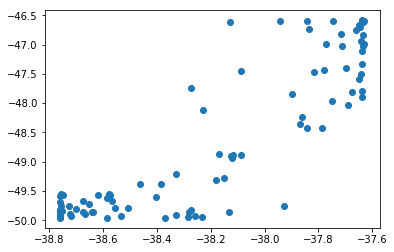

In [70]:
%matplotlib inline
from pylab import *
plt.plot(rewards[:,0], rewards[:,1], 'o')

In [ ]:
policy_parameters

In [ ]:
policy[2].epsilon = 0.1

In [ ]:
all_states = []
all_actions = []

num_episode = 10

num_grad_steps = 100
learning_rate = 1e-1
use_random_policy = False

for i_ep in range(num_episode):
    print('Start Episode '+str(i_ep+1)+'.')
    
    # Run an episode and collect data.    
    if i_ep==0 and use_random_policy:
        print("Using random policy")
        policy_func = random_policy       
        learning_rate = 1e-1
    else:
        print("Using learned policy")
        policy_func = lambda x: policy(mx.nd.expand_dims(mx.nd.array(x, dtype='float64'), axis=0)).asnumpy()[0]
        learning_rate = 1e-1
    total_reward, states, actions = run_one_episode(env, policy_func, max_steps=100, render=True)
    print("Actions:", actions[:10], actions[-10:])
    all_states.append(states)
    all_actions.append(actions)
    
    # Fit a model.
    print('Fit the model.')
    model, infr = fit_model(all_states, all_actions, win_in=1, verbose=False)
        
    # Optimize the policy.
    print('Optimize the policy.')
    policy = optimize_policy(policy, cost, model,
                             infr, initial_state_generator,
                             num_grad_steps=num_grad_steps, 
                             num_samples=num_samples,
                             learning_rate=learning_rate)

1. update the optimize policy fuction.
2. multiple initial states.
3. use the real reward function. (https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py)
4. visualize the intermediate and final performance of policy.
5. Make a notebook to show.
6. Try a non-linear policy.
7. add epsilon-greedy policy

In [ ]:
env.env.state

In [ ]:
env.render()

In [ ]:
-env.env.state[0]

In [ ]:
np.sin(-env.env.state[0])

In [ ]:
np.cos(all_states[1][-1][0])



In [ ]:
debug

In [ ]:
all_actions

In [ ]:
parameters1 = run_one_episode(env, policy_func, max_steps=10000, render=True)

In [ ]:
parameters1[2]

In [ ]:
policy[0].collect_params()['dense0_weight'].set_data(mx.nd.array([[-2.26582996, -4.80595503]], dtype='float64'))
policy[0].collect_params()['dense0_bias'].set_data(mx.nd.array([1.73686036], dtype='float64'))

In [ ]:
parameters1 = run_one_episode(env, policy_func, max_steps=10000, render=True)